# Machine Learning Simulation Coursework - Perceptron
Maximilian Zebhauser

### Task: 
Write a program that implements the perceptron algorithm and test the running 
time and the probability of error of the resulting linear classifier. 
Consider both linearly separable and non-separable data.

For the linearly separable case, you may generate (X, Y ) pairs (with $X \in 
\mathbb{R}^{d} \text { and } Y \in\{-1,1\} $) such that $P\{Y=1\}=1 / 2$ and, 
conditionally on Y = 1, X is uniformly distributed in $ [-1,-a] \times [-1,1] \times \cdots \times[-1,1] $
(i.e., the first component of X is uniform between -1 and a and the rest are 
uniform in $[-1, 1]$) while, conditionally on Y = -1, X is uniformly distributed 
in $[a, 1] \times[-1,1] \times \cdots \times[-1,1] $. Here $a \in [0, 1]$ is a 
parameter, playing the role of the margin. Try different values of a,d and 
different sample sizes. Run the algorithm many times for each data 
set to estimate the number of updates until the algorithm stops and generate 
independent data to estimate the probability of error.

For the non-separable case, generate the two class-conditional distributions 
as multivariate normals with means (0, . . . , 0) and (m, 0, 0, . . . , 0) and 
identity covariance matrix. Here the algorithm never stops making updates so run 
it by passing through the data set several times and define a stopping time. 
Again, test the performance of the classifier for several sample sizes, 
dimensions, and choices of m. Compare the obtained probability of error 
to the Bayes risk.
### Theoretical Background: 
The Perceptron algorithm is a linear classifier with the following classification rule: 
$$ g(X)=\operatorname{sign}\left(w^{T} X\right) $$
If and only if the data is separable the algorithm converges in $\left(\frac{R}{\gamma}\right)^{2}$ 
updates according to Norikov's theorem.
### Answer: 
We know the perceptron classifier has the following decision rule:
$$ g^{*}(x^{(1)})=\left\{\begin{array}{ll}{ 1} & {\text { if }  x^{(1)} > 0} \\ {-1} & {\text { if } x^{(1)} \leq 0}  \end{array}\right.$$	

Then, we derive the Bayes Risk $R ^ { * }$ using the property that $Y=-1$ if 
$x^{(1)} \sim N\left( 0 , 1\right) $ and $Y=1$ if $x^{(1)} \sim N\left(m, 1\right)$. 
In the last step we make use of the CDF of the standard normal $\Phi$ for 
rescaling the latter of both distributions:
$$ \begin{aligned} R ^ { * } = R \left( g ^ { * } \right) & = P ( g ( x ) = 1 | Y = -1 ) \cdot q _ { 0 } + P_m ( g ( x ) = -1 | Y = 1 ) \cdot q _ { 1 } \\ & = \frac{1}{2} P ( g ( x ) = 1 | Y = -1 ) + \frac{1}{2}  P_m ( g ( x ) = -1 | Y = 1 ) \\ & = \frac{1}{4} + \frac{1}{2} P_m ( g ( x ) = -1 | Y = 1 ) \\ & = \frac{1}{4} + \frac{1}{2} P_m ( x \leq 0 | Y = 1 ) = \frac{1}{4} + \frac{1}{2} \cdot \Phi(0-m) \\ & = \frac{1}{4} + \frac{1}{2} \cdot \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{-m} e^{-t^{2} / 2} d t \\ & \implies \lim_{m \to \infty} R^* = \frac{1}{4} \end{aligned}$$

Clearly the second term vanishes with large m. 

For all simulations the average is formed over ransom 500 samples. 
The test data to empirically estimate the risk has the same size as the training data set 
used to train the perceptron.

We know that the maximum number of updates until the algorithm converges in the 
separable case is bounded $(R / \gamma)^{2}$ without dependency on the dimensions, 
which is clearly visible in the plots below. On the other hand, the empirical risk 
seems to grow with the number of dimensions, which is supported by the fact that 
the class is only dependent on the first component of the input data and, 
therefore, the additional dimensions only add random noise.

In the non-separable case, the Bayes risk shows the lower bound for the risk 
that can be achieved in the optimum. We can clearly observe that the risk is on 
average close to the bayes risk. As $m$ grows the the empirical risk converges 
to the bayes risk.
### Supporting Code & Plots:

In [1]:
# Packages
require(MASS)
require(doParallel)
require(foreach)
require(RColorBrewer)
require(MASS)

# Functions
separable_data <- function(a, d, n){
    Y <- sign(runif(n,-1,1))
    X_1 <- ifelse(Y > 0, runif(n, -1, -a), runif(n, a, 1))
    X_d <- matrix(runif(n*(d-1),-1,1), nrow = n, byrow = F)
    cbind(Y, X_1, X_d)
}

non_separable_data <- function(m, d, n){
    Y <- sign(runif(n,-1,1))
    X_1 <- ifelse(Y > 0, rnorm(n, m), rnorm(n))
    X_d <- mvrnorm(n, rep(0,(d-1)), diag((d-1)))
    cbind(Y, X_1, X_d)
}

perc_alg <- function(dat, data_seperable = T, max.iter=10000){
    w <- rep(0, ncol(dat) - 1); counter <- 0; update <- rep(T, nrow(dat))
    if(! data_seperable) {dat <- apply(dat, 2, function(inp) inp - mean(inp))}
    while(sum(update) > 0){
        update <- rep(T, nrow(dat))
        for(i in 1:nrow(dat)){
            if(dat[i,1] * (w %*% dat[i,2:ncol(dat)]) <= 0){
                w <- w + dat[i,1] %*% dat[i,2:ncol(dat)]
                counter <- counter + 1
            }
            if(counter == max.iter) break
            else {update[i] <- F}
        }
        if(counter == max.iter) break
    }
    list(w,(counter - 1))
}

Loading required package: MASS
Loading required package: doParallel
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: RColorBrewer


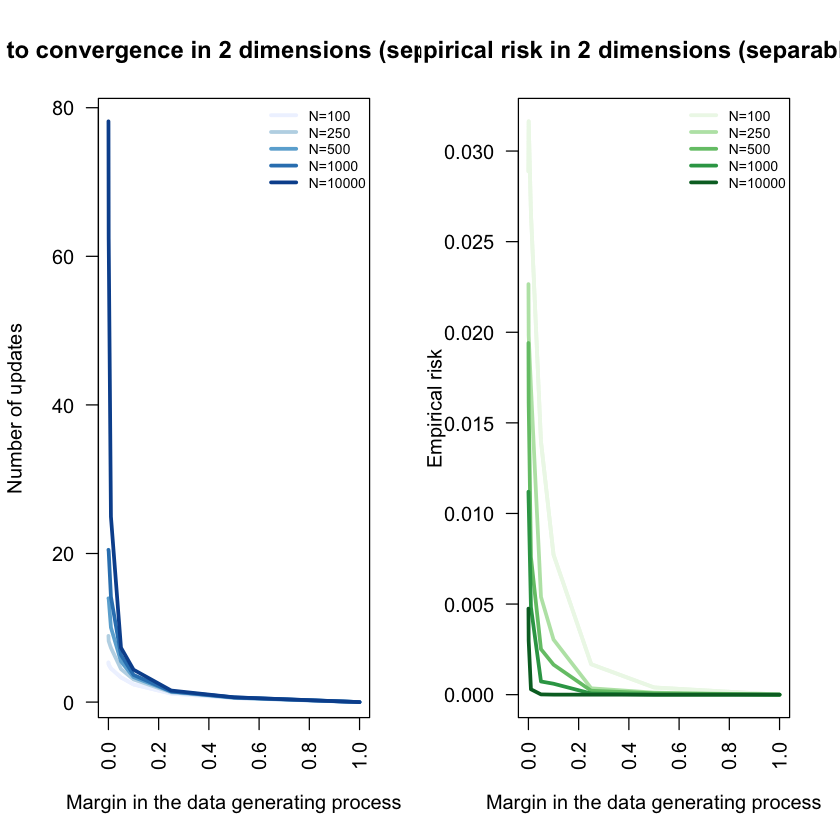

In [2]:
# Analysis separable case ====
N_1 <- c(100,250,500,1000,10000)
A_1 <- c(1,.5,.25,.1,.05,.01,.001,.0001)
D_1 <- c(2,10,50,100)
list_iterations <- list()
list_risk <- list()
cl <- makeCluster(detectCores() - 1)
registerDoParallel(cl)
for(D_iter in 1:length(D_1)){
    for(N_iter in 1:length(N_1)){
        list_iterations[[N_iter]] <- rep(0,length(A_1))
        list_risk[[N_iter]]       <- rep(0,length(A_1))
        for(A_iter in 1:length(A_1)){
            zwischen <- foreach(i = 1:250,.combine = c,.multicombine = T, .packages = "MASS") %dopar% {
                alg_res  <- perc_alg(separable_data(A_1[[A_iter]],D_1[D_iter],N_1[[N_iter]]))
                alg_risk <- sum(apply(separable_data(A_1[[A_iter]],D_1[D_iter],N_1[[N_iter]]), 
                                      1, function(C) C[1] * (alg_res[[1]] %*% C[2:length(C)]) <= 0))
                list(alg_res[[2]],alg_risk / N_1[[N_iter]])
            }
            list_iterations[[N_iter]][A_iter] <- mean(matrix(unlist(zwischen), ncol = 2,byrow = T)[,1])
            list_risk[[N_iter]][A_iter]       <- mean(matrix(unlist(zwischen), ncol = 2,byrow = T)[,2])
        }
    }
    result_iterations <- matrix(unlist(list_iterations),ncol = length(A_1), byrow = T, dimnames = list(unlist(N_1),unlist(A_1)))
    result_risk       <- matrix(unlist(list_risk),ncol = length(A_1), byrow = T, dimnames = list(unlist(N_1),unlist(A_1)))
    par(mfrow=c(1,2))
    mypalette <- brewer.pal(length(N_1),"Blues")
    plot(unlist(A_1),result_iterations[1,],type="l",col=mypalette[1], lwd=3, ylim= c(1,max(result_iterations)),
         ylab="Number of updates",xlab="Margin in the data generating process",
         main=paste0("Updates to convergence in ", D_1[D_iter]," dimensions (separable data)"), las=2)
    for(i in 1:length(N_1)) lines(unlist(A_1),result_iterations[i,],col=mypalette[i],lwd=3)
    legend("topright", paste0("N=",unlist(N_1)), col = mypalette, lwd = 3, cex = .7, bty="n")
    mypalette <- brewer.pal(length(N_1),"Greens")
    plot(unlist(A_1),result_risk[1,],type="l",col=mypalette[1], lwd=3, ylim= c(0,max(result_risk)),
         ylab="Empirical risk",xlab="Margin in the data generating process",
         main=paste0("Empirical risk in ", D_1[D_iter]," dimensions (separable data)"), las=2)
    for(i in 1:length(N_1)) lines(unlist(A_1),result_risk[i,],col=mypalette[i],lwd=3)
    legend("topright", paste0("N=",unlist(N_1)), col = mypalette, lwd = 3, cex = .7, bty="n")
}
stopCluster(cl)

In [ ]:
# Analysis non-separable case ====
N_1 <- c(100,250,500,1000,10000)
M_1 <- c(0,2.5,5,7.5,10,15)
D_1 <- c(2,10,50,100)
list_risk <- list()
cl <- makeCluster(detectCores() - 1)
registerDoParallel(cl)
for(D_iter in 1:length(D_1)){
    for(N_iter in 1:length(N_1)){
        list_risk[[N_iter]] <- rep(0,length(M_1))
        for(M_iter in 1:length(M_1)){
            zwischen <- foreach(i = 1:250, .packages = "MASS") %dopar% {
                alg_res  <- perc_alg(non_separable_data(M_1[M_iter],D_1[D_iter],N_1[N_iter]))
                test_data <- non_separable_data(M_1[M_iter],D_1[D_iter],N_1[N_iter])
                #test_data <- apply(test_data, 2, function(inp) inp - mean(inp))
                sum(apply(test_data, 1, function(C) C[1] * (alg_res[[1]] %*% C[2:length(C)]) <= 0)) / N_1[N_iter]
            }
            list_risk[[N_iter]][M_iter] <- mean(unlist(zwischen))
        }
    }
    result_risk <- matrix(unlist(list_risk),ncol = length(M_1), byrow = T, dimnames = list(unlist(N_1),unlist(M_1)))
    mypalette <- brewer.pal(length(N_1),"Greens")
    par(mfrow=c(2,2))
    plot(M_1,result_risk[1,],type="l",col=mypalette[1], lwd=3, ylim= c(.25,max(result_risk)),
         ylab="Empirical risk",xlab="Size of the mean m",
         main=paste0("Empirical risk in ", D_1[D_iter]," dimensions (non-separable data)"), las=2)
    mus <- seq(min(M_1),max(M_1),.1)
    bayes <- .5 * (1- pnorm(0, mean = 0) + pnorm(0, mean = mus))
    lines(mus,bayes, lwd=3, col="tomato")
    for(i in 1:length(N_1)) lines(M_1,result_risk[i,],col=mypalette[i],lwd=3)
    legend("topright", c("Bayes Risk",paste0("N=",unlist(N_1))), col = c("tomato",mypalette), lwd = 3, cex = .7, bty="n")
}
stopCluster(cl)